# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from sklearn.svm import LinearSVC
from scipy.ndimage.interpolation import rotate
import imgaug.augmenters as iaa

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  img = img.astype('float64')
  img = 2 * ((img - np.min(img) / np.max(img) - np.min(img))) - 1
  return img

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False, random_augment=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

    if random_augment:
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        seq = iaa.Sequential([
            sometimes(iaa.AffineCv2(rotate=np.random.choice(range(5,85,5)))),
            iaa.Crop(px=(1, 24), keep_size=True)
        ])
        aug_data = seq(images=data)
        plt.imshow(data[-1], 'gray')
        plt.show()
        # aug_data = [rotate(img, np.random.choice([90,180,270]), reshape=False) for img in data]
        plt.imshow(aug_data[-1], 'gray')
        plt.show()
        data.extend(aug_data)
        labels.extend(labels)        
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    if zero_centered:
      data -= np.mean(data, axis = 0)
      data /= np.std(data, axis = 0)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Coast', 1: 'Flower', 2: 'Bedroom', 3: 'Forest', 4: 'Office', 5: 'Industrial', 6: 'Street', 7: 'LivingRoom', 8: 'Store', 9: 'Kitchen', 10: 'Highway', 11: 'OpenCountry', 12: 'Mountain', 13: 'InsideCity', 14: 'TallBuilding', 15: 'Suburb', 16: '_DS_Store'} 


In [9]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class:

Suburb


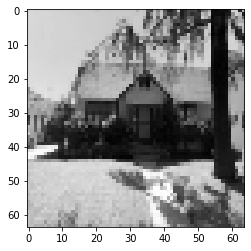

In [10]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# accuracy in percentage of given network and dataset
def evaluate(net, loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in loader:
          
          images, labels = data

          net = net.to(device)
          images, labels = images.to(device), labels.to(device)

          outputs = net(images.float())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

# to print stats at each epoch during the training
def get_stats(net, epoch, criterion, trainloader, testloader, running_loss):
  train_minibatches, test_minibatches = len(trainloader), len(testloader)
  val_loss = 0.0
  for test_i, test_data in enumerate(testloader, 0):
    test_inputs, test_labels = test_data

    net = net.to(device)
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

    test_outputs = net(test_inputs.float())
    test_loss = criterion(test_outputs, test_labels)
    val_loss += test_loss.item()

  train_loss = running_loss/train_minibatches
  val_loss = val_loss/test_minibatches
  train_acc = evaluate(net, trainloader)
  val_acc = evaluate(net, testloader)

  print('%d => train_loss: %.3f, train_accuracy: %.2f, val_loss: %.3f, val_accuracy: %.2f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc))
  return train_loss, train_acc, val_loss, val_acc

# to plot graphs
def plot(epochs, tr_loss, val_loss, tr_acc, val_acc):
  plt.plot(range(1,epochs+1), tr_loss, label = 'TrainLoss')
  plt.plot(range(1,epochs+1), val_loss, label = 'ValLoss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(range(1,epochs+1), tr_acc, label = 'TrainAcc')
  plt.plot(range(1,epochs+1), val_acc, label = 'ValAcc')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

### **Part 1 (60.00% accuracy, 55 epochs, 32 seconds)**

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

nclass = 16
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(32 * 6 * 6, 576)
        self.fc2 = nn.Linear(576, 576)
        self.fc3 = nn.Linear(576, nclass)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        x = self.pool(F.relu(x))
        x = x.view(-1, 32 * 6 * 6)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(epochs = 50):
  
  net = Net().float()

  net = net.to(device)
          
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.0005)
  train_minibatches = len(trainloader_small)
  tr_loss, v_loss, tr_acc, v_acc = [], [], [], []
  counter = 0
  
  for epoch in range(epochs):
      net.train()
      random.shuffle(trainloader_small)
      running_loss = 0.0
      for i, data in enumerate(trainloader_small, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          
          outputs = net(inputs.float())
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % train_minibatches == train_minibatches-1:
              net.eval()
              train_loss, train_acc, val_loss, val_acc = get_stats(net, epoch, criterion, trainloader_small, testloader_small, running_loss)

              tr_loss.append(train_loss)
              v_loss.append(val_loss)
              tr_acc.append(train_acc)
              v_acc.append(val_acc)

              running_loss = 0.0
  print('Finished Training')
  return net, epochs, tr_loss, v_loss, tr_acc, v_acc 

1 => train_loss: 2.579, train_accuracy: 28.06, val_loss: 2.268, val_accuracy: 26.75
2 => train_loss: 2.102, train_accuracy: 38.73, val_loss: 1.976, val_accuracy: 37.75
3 => train_loss: 1.895, train_accuracy: 46.92, val_loss: 1.753, val_accuracy: 41.50
4 => train_loss: 1.712, train_accuracy: 49.85, val_loss: 1.688, val_accuracy: 44.50
5 => train_loss: 1.604, train_accuracy: 55.52, val_loss: 1.529, val_accuracy: 48.50
6 => train_loss: 1.481, train_accuracy: 57.83, val_loss: 1.553, val_accuracy: 46.25
7 => train_loss: 1.420, train_accuracy: 62.54, val_loss: 1.460, val_accuracy: 51.50
8 => train_loss: 1.386, train_accuracy: 63.90, val_loss: 1.408, val_accuracy: 50.50
9 => train_loss: 1.295, train_accuracy: 66.94, val_loss: 1.376, val_accuracy: 53.50
10 => train_loss: 1.242, train_accuracy: 68.81, val_loss: 1.328, val_accuracy: 53.25
11 => train_loss: 1.190, train_accuracy: 72.25, val_loss: 1.291, val_accuracy: 53.50
12 => train_loss: 1.123, train_accuracy: 73.29, val_loss: 1.300, val_accur

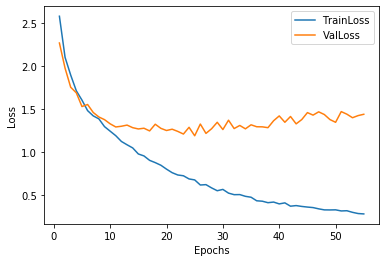

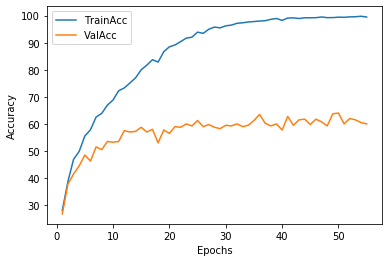

In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
since = time.time()
net, epochs, tr_loss, val_loss, tr_acc, val_acc = train(epochs=55)
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(net, testloader_small)

time_elapsed = time.time() - since
print('Evaluating completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Evaluating completed in 0m 0s
Accuracy on test dataset 60.0 %


**Description!**
*   Data augmentation: Each image is flipped at axis 1 using numpy and appended to the dataset, all the labels are appened again in labels as labels will remain same even after flipping images.
*   Data normalization: Each image array values are subtracted and divided by that particular image's mean and standard deviation respectively. From experience, such normalization is really helpful.

```
1.   [Convolution1] InputF: 1, OutputF: 2, KernelSize: 3, Padding: 2
2.   [Activation] RELU
3.   [Pooling] Maxpooling by size 2

4.   [Convolution2] InputF: 2, OutputF: 16, KernelSize: 3
5.   [Activation] RELU
6.   [Pooling] Maxpooling by size 2

6.   [Convolution2] InputF: 16, OutputF: 32, KernelSize: 3
7.   [Activation] RELU
8.   [Pooling] Maxpooling by size 2

9.   [Dropout] p = 0.5

10.  [FC]  InputF: 1152, OutputF: 576
11.  [Activation] RELU

12.   [Dropout] p = 0.5

13.  [FC]  InputF: 576, OutputF: 576
14.  [Activation] RELU

15.  [FC]  InputF: 576, OutputF: 16
```

> Training Time: **32 seconds**; 
Testing Time: **0 seconds (< 0 ms)**; 
Accuracy on Test set: **60.00%**
 





### **Part 2** Experiments with three techniques!

#### **1) Randomly Rotating Training Image (62% accuracy, 55 epochs, 2 minutes 18 seconds)**

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16


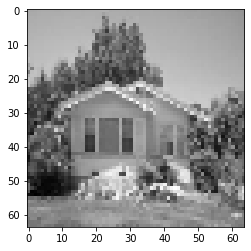

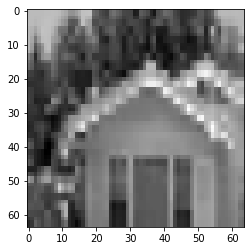

9600
50
Finish loading 192 minibatches(=50) of training samples.


In [13]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_aug = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True, random_augment=True))
train_num = len(trainloader_aug)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

nclass = 16
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(32 * 6 * 6, 576)
        self.fc2 = nn.Linear(576, 576)
        self.fc3 = nn.Linear(576, nclass)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        x = self.pool(F.relu(x))
        x = x.view(-1, 32 * 6 * 6)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train(epochs = 50):
  
  net = Net().float()
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.0005)
  train_minibatches = len(trainloader_aug)
  tr_loss, v_loss, tr_acc, v_acc = [], [], [], []
  counter = 0

  for epoch in range(epochs):
      net.train()
      random.shuffle(trainloader_aug)
      running_loss = 0.0
      for i, data in enumerate(trainloader_aug, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          
          outputs = net(inputs.float())
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % train_minibatches == train_minibatches-1:
              net.eval()
              train_loss, train_acc, val_loss, val_acc = get_stats(net, epoch, criterion, trainloader_aug, testloader_small, running_loss)

              tr_loss.append(train_loss)
              v_loss.append(val_loss)
              tr_acc.append(train_acc)
              v_acc.append(val_acc)

              running_loss = 0.0
  print('Finished Training')
  return net, epochs, tr_loss, v_loss, tr_acc, v_acc 

1 => train_loss: 2.602, train_accuracy: 23.53, val_loss: 2.340, val_accuracy: 27.50
2 => train_loss: 2.343, train_accuracy: 31.05, val_loss: 2.055, val_accuracy: 33.00
3 => train_loss: 2.166, train_accuracy: 37.57, val_loss: 1.836, val_accuracy: 39.75
4 => train_loss: 2.045, train_accuracy: 40.82, val_loss: 1.768, val_accuracy: 41.25
5 => train_loss: 1.944, train_accuracy: 43.09, val_loss: 1.695, val_accuracy: 40.50
6 => train_loss: 1.856, train_accuracy: 47.52, val_loss: 1.605, val_accuracy: 47.25
7 => train_loss: 1.783, train_accuracy: 51.70, val_loss: 1.495, val_accuracy: 50.50
8 => train_loss: 1.706, train_accuracy: 54.25, val_loss: 1.445, val_accuracy: 54.25
9 => train_loss: 1.654, train_accuracy: 56.01, val_loss: 1.421, val_accuracy: 54.25
10 => train_loss: 1.611, train_accuracy: 58.79, val_loss: 1.360, val_accuracy: 55.75
11 => train_loss: 1.547, train_accuracy: 59.40, val_loss: 1.419, val_accuracy: 52.00
12 => train_loss: 1.494, train_accuracy: 62.88, val_loss: 1.351, val_accur

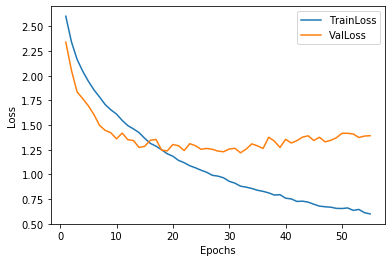

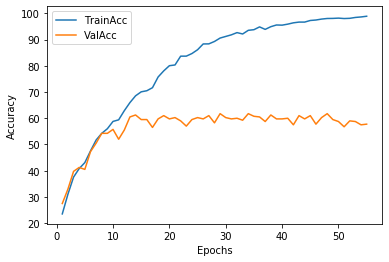

In [15]:
# ==========================================
#         Optimize/Train Network
# ==========================================
since = time.time()
net, epochs, tr_loss, val_loss, tr_acc, val_acc = train(epochs=55)
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [19]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(net, testloader_small)

time_elapsed = time.time() - since
print('Evaluating completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Evaluating completed in 0m 0s
Accuracy on test dataset 62.0 %


**Description!**


> This was the code of random augmentation.


```
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
    sometimes(iaa.AffineCv2(rotate=np.random.choice(range(5,85,5)))),
    iaa.Crop(px=(1, 24), keep_size=True)
])
aug_data = seq(images=data)
```


> Here, I am applying **Affine transformation** with random rotation from list of angles [5,85] (increased by 5) with occuring probability of 50%. Then **zooming** is done upto 24 size from 64 size of image keeping same image size(interpolated). I explored the test data and training data, where primary objects were nearer or far, they had a perspective transformation effect and many more. Therefore, this augmentation looked good to me to begin with.
With **only a change of dataset in configuration of part 1**, performance improved upto **62%**!




#### **2) Adding Batch Normalization (63.25 % accuracy, 55 epochs, 32 seconds)**

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

nclass = 16
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.BN1 = nn.BatchNorm2d(2)
        self.conv2 = nn.Conv2d(2, 16, 3)
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.BN3 = nn.BatchNorm2d(32)
        self.drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(32 * 6 * 6, 576)
        self.fc2 = nn.Linear(576, 576)
        self.fc3 = nn.Linear(576, nclass)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.BN1(x) # added
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.BN2(x) # added
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.BN3(x) # added
        x = self.pool(x)
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(epochs = 50):
  
  net = Net().float()
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # changed
  train_minibatches = len(trainloader_small)
  tr_loss, v_loss, tr_acc, v_acc = [], [], [], []
  counter = 0

  for epoch in range(epochs):
      net.train()
      random.shuffle(trainloader_small)
      running_loss = 0.0
      for i, data in enumerate(trainloader_small, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          
          outputs = net(inputs.float())
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % train_minibatches == train_minibatches-1:
              net.eval()
              train_loss, train_acc, val_loss, val_acc = get_stats(net, epoch, criterion, trainloader_small, testloader_small, running_loss)

              tr_loss.append(train_loss)
              v_loss.append(val_loss)
              tr_acc.append(train_acc)
              v_acc.append(val_acc)

              running_loss = 0.0
  print('Finished Training')
  return net, epochs, tr_loss, v_loss, tr_acc, v_acc 

1 => train_loss: 2.723, train_accuracy: 20.77, val_loss: 2.659, val_accuracy: 16.25
2 => train_loss: 2.538, train_accuracy: 28.69, val_loss: 2.443, val_accuracy: 26.50
3 => train_loss: 2.283, train_accuracy: 37.06, val_loss: 2.124, val_accuracy: 34.75
4 => train_loss: 2.026, train_accuracy: 42.10, val_loss: 1.900, val_accuracy: 39.00
5 => train_loss: 1.841, train_accuracy: 47.31, val_loss: 1.757, val_accuracy: 46.00
6 => train_loss: 1.680, train_accuracy: 52.25, val_loss: 1.640, val_accuracy: 47.00
7 => train_loss: 1.548, train_accuracy: 56.81, val_loss: 1.556, val_accuracy: 51.25
8 => train_loss: 1.424, train_accuracy: 61.65, val_loss: 1.428, val_accuracy: 54.25
9 => train_loss: 1.314, train_accuracy: 63.96, val_loss: 1.363, val_accuracy: 55.00
10 => train_loss: 1.240, train_accuracy: 66.54, val_loss: 1.327, val_accuracy: 57.75
11 => train_loss: 1.152, train_accuracy: 64.79, val_loss: 1.445, val_accuracy: 54.25
12 => train_loss: 1.098, train_accuracy: 69.67, val_loss: 1.312, val_accur

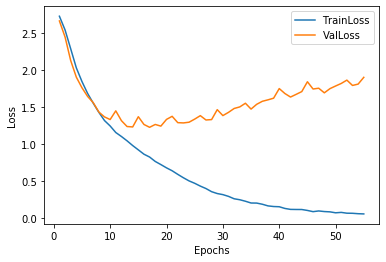

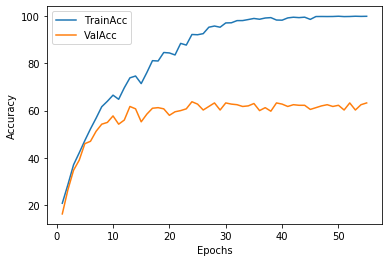

In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
since = time.time()
net, epochs, tr_loss, val_loss, tr_acc, val_acc = train(epochs=55)
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(net, testloader_small)

time_elapsed = time.time() - since
print('Evaluating completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Evaluating completed in 0m 0s
Accuracy on test dataset 63.25 %


**Description!**


> In part 1, model got overfitting at a point, so to reduce overfitting dropout layers were used. However, batch normalization layer also provides regularization efficiently. In this approach, I added **3 batchNorm layers** right after activation layers of 3 convolution layers. I also changed **optimizer to SGD** with a momentum usage (Optimizer was Adam earlier). Training on **same dataset as of part 1** with only these 2 changes, improved performance upto **63.25%**. Here I believe, modifying few parameters of layers could perform even better than this.



#### **3) Trying Different Activation Function (SELU - 62% accuracy, 55 epochs, 2 minutes 15 seconds)**

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

nclass = 16
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.BN1 = nn.BatchNorm2d(2)
        self.conv2 = nn.Conv2d(2, 16, 3)
        self.BN2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.BN3 = nn.BatchNorm2d(32)
        self.drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(32 * 6 * 6, 576)
        self.fc2 = nn.Linear(576, 576)
        self.fc3 = nn.Linear(576, nclass)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.selu(x)) # SELU
        x = self.BN1(x)
        x = self.conv2(x)
        x = self.pool(F.selu(x)) # SELU
        x = self.BN2(x)
        x = self.conv3(x)
        x = self.pool(F.selu(x)) # SELU
        x = self.BN3(x)
        x = x.view(-1, 32 * 6 * 6)
        x = self.drop(x)
        x = F.selu(self.fc1(x)) # SELU
        x = self.drop(x)
        x = F.selu(self.fc2(x)) # SELU
        x = self.fc3(x)
        return x

def train(epochs = 20):
  
  net = Net().float()
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.0007, momentum=0.7) # change
  train_minibatches = len(trainloader_aug)
  tr_loss, v_loss, tr_acc, v_acc = [], [], [], []
  counter = 0

  for epoch in range(epochs):
      net.train()
      random.shuffle(trainloader_aug)
      running_loss = 0.0
      for i, data in enumerate(trainloader_aug, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          
          outputs = net(inputs.float())
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if i % train_minibatches == train_minibatches-1:
              net.eval()
              train_loss, train_acc, val_loss, val_acc = get_stats(net, epoch, criterion, trainloader_aug, testloader_small, running_loss)

              tr_loss.append(train_loss)
              v_loss.append(val_loss)
              tr_acc.append(train_acc)
              v_acc.append(val_acc)

              running_loss = 0.0
  print('Finished Training')
  return net, epochs, tr_loss, v_loss, tr_acc, v_acc 

1 => train_loss: 2.702, train_accuracy: 21.70, val_loss: 2.441, val_accuracy: 25.75
2 => train_loss: 2.520, train_accuracy: 24.84, val_loss: 2.279, val_accuracy: 32.25
3 => train_loss: 2.420, train_accuracy: 27.35, val_loss: 2.171, val_accuracy: 34.00
4 => train_loss: 2.360, train_accuracy: 29.47, val_loss: 2.091, val_accuracy: 36.75
5 => train_loss: 2.308, train_accuracy: 31.02, val_loss: 2.038, val_accuracy: 35.00
6 => train_loss: 2.268, train_accuracy: 32.17, val_loss: 1.961, val_accuracy: 37.75
7 => train_loss: 2.226, train_accuracy: 33.21, val_loss: 1.916, val_accuracy: 39.50
8 => train_loss: 2.203, train_accuracy: 34.05, val_loss: 1.877, val_accuracy: 39.00
9 => train_loss: 2.170, train_accuracy: 35.09, val_loss: 1.855, val_accuracy: 39.50
10 => train_loss: 2.149, train_accuracy: 36.07, val_loss: 1.809, val_accuracy: 41.25
11 => train_loss: 2.130, train_accuracy: 36.96, val_loss: 1.821, val_accuracy: 40.25
12 => train_loss: 2.099, train_accuracy: 37.95, val_loss: 1.781, val_accur

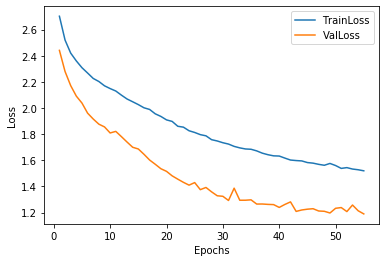

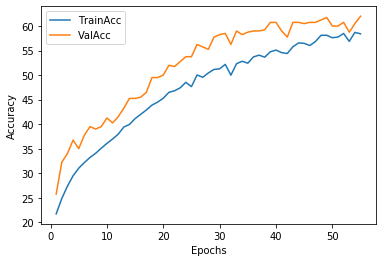

In [17]:
# ==========================================
#         Optimize/Train Network
# ==========================================
since = time.time()
net, epochs, tr_loss, val_loss, tr_acc, val_acc = train(epochs=55)
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [18]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(net, testloader_small)

time_elapsed = time.time() - since
print('Evaluating completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Evaluating completed in 0m 0s
Accuracy on test dataset 62.0 %


**Description!**


> This one was interesting. This implementation is same as Part 2: 1) random rotate except I changed **activation function to SELU** (Scaled Exponential Linear Units) from RELU and changed **optimizer to SGD** again. Here preferring SELU over RELU was based on, SELUs cannot die whereas RELUs do(vanishing gradient problem). SELU has one more advantage of self normalization that is why I **didn't use batchNorm layers** here. Results show significant improvements not in terms of accuracy though i.e. **62%**. Comparing 1st experiment with this one, here I don't see overfitting yet (from the loss-epoch plots) and tweaking few parameters would definitely show improvement in accuracy too for same number of epochs. This network was trained on **random augmented dataset same as used in experiment 1**. I also tried sigmoid activation function which did not perform well compared to RELU. I believe reasons would be sigmoid's saturation and killing gradients, plus its outputs are not zero centered whereas RELU has its own advantages too (other than RELU is good at what sigmoid is bad at) which are computationally efficient and faster convergence rate.



## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class:

### **Part 1 Strategy B: Fine-Tune a pre-trained AlexNet (85.5% accuracy, 10 epochs, 27 seconds)**

In [0]:
from torchvision import models
import torch.optim as optim
import time, copy
nclass = 16

alexnet = models.alexnet(pretrained=True)
print(alexnet)


for param in alexnet.features.parameters():
    param.requires_grad = False

del alexnet.classifier[5:]
num_ftrs = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_ftrs, nclass)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for name, param in alexnet.named_parameters():
    if param.requires_grad:
        print(name, param.requires_grad)

classifier.1.weight True
classifier.1.bias True
classifier.4.weight True
classifier.4.bias True


In [0]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
def train_model(net, epochs=10):
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    since = time.time()

    import gc
    gc.collect()
    train_minibatches = len(trainloader_large)
    tr_loss, v_loss, tr_acc, v_acc = [], [], [], []
    for epoch in range(epochs):
      random.shuffle(trainloader_large)
      running_loss = 0.0
      scheduler.step()
      net.train()
      for i, data in enumerate(trainloader_large, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(True):
                outputs = net(inputs.float())
          
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # scheduler.step()
                running_loss += loss.item()
                if i % train_minibatches == train_minibatches-1:
                    net.eval()
                    train_loss, train_acc, val_loss, val_acc = get_stats(net, epoch, criterion, trainloader_large, testloader_large, running_loss)

                    tr_loss.append(train_loss)
                    v_loss.append(val_loss)
                    tr_acc.append(train_acc)
                    v_acc.append(val_acc)

                    running_loss = 0.0

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return net, epochs, tr_loss, v_loss, tr_acc, v_acc

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

alexnet_trained, epochs, tr_loss, val_loss, tr_acc, val_acc = train_model(alexnet, epochs=10)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


1 => train_loss: 0.256, train_accuracy: 98.62, val_loss: 0.982, val_accuracy: 83.00
2 => train_loss: 0.588, train_accuracy: 95.92, val_loss: 1.235, val_accuracy: 79.00
3 => train_loss: 0.811, train_accuracy: 98.04, val_loss: 1.338, val_accuracy: 81.00
4 => train_loss: 0.603, train_accuracy: 98.58, val_loss: 1.066, val_accuracy: 85.50
5 => train_loss: 0.675, train_accuracy: 99.12, val_loss: 1.270, val_accuracy: 81.00
6 => train_loss: 0.452, train_accuracy: 98.96, val_loss: 1.451, val_accuracy: 81.75
7 => train_loss: 0.286, train_accuracy: 99.83, val_loss: 1.025, val_accuracy: 82.75
8 => train_loss: 0.184, train_accuracy: 99.83, val_loss: 0.881, val_accuracy: 84.50
9 => train_loss: 0.180, train_accuracy: 99.88, val_loss: 0.853, val_accuracy: 85.00
10 => train_loss: 0.130, train_accuracy: 100.00, val_loss: 0.757, val_accuracy: 85.50
Training complete in 0m 27s


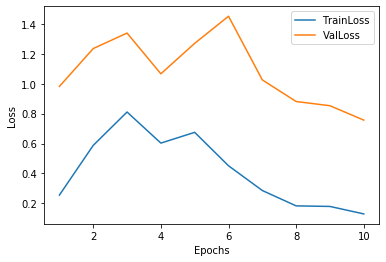

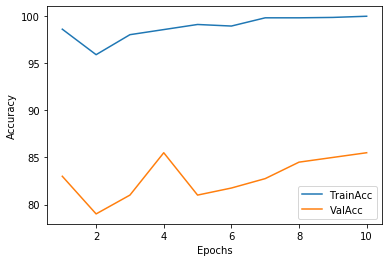

In [0]:
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(alexnet_trained, testloader_large)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Training complete in 0m 0s
Accuracy on test dataset 85.5 %


**Description!**

> Alexnet being a large network and trained on large dataset have highly good feature extracter layers so they were freezed in the begining. I had an instinct that if I freeze all feature extracter layers (as believed) and train the classifier layers on the given small dataset, it should perform well. However, having a small dataset, and having 3 FC layers with higher number of features it would be prone to overfitting. So I **removed the last FC layer**, changed **output features of second last layer to number of class (=16)** and kept third last layer (first in classifier layers) untouched. **freezed Alexnet initial layers** (already trained probably feature extracting layers) and **2 trainable layers of Alexnet classifier** with **relu activation layers** (by default from alexnet) were trained on **training dataset (zero centered, no augmentation)** for **10 epochs** (taking **27 seconds**) and achieved **85.5%** accuracy on given test dataset (taking **0 seconds**).






### **Part 2 Strategy A:  Train one-vs-all SVMs (75.75% accuracy, 36 seconds)**

In [0]:
alexnet = models.alexnet(pretrained=True)
# alexnet = alexnet.to(device)
del alexnet.classifier[-1]

features = 1200

trainlarge_imgs = []
trainlarge_labels = []


In [0]:
# ==========================================
#         Optimize/Train Model
# ==========================================
since = time.time()

for data, labels in trainloader_large:
    # data, labels = data.to(device), labels.to(device)
    trainlarge_imgs.extend(alexnet(data.float())[:, :features].detach().numpy())
    trainlarge_labels.extend(labels.detach().numpy())

trainlarge_imgs = np.vstack(trainlarge_imgs)
trainlarge_labels = np.hstack(trainlarge_labels)

svc = LinearSVC()
svc.fit(trainlarge_imgs, trainlarge_labels)

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Training completed in 0m 36s


In [0]:
# ==========================================
#            Evaluating Model
# ==========================================

since = time.time()

correct = 0
total = 0
for data, labels in testloader_large:
    predicted = svc.predict(alexnet(data.float())[:, :features].detach().numpy())
    correct += np.sum(predicted == labels.detach().numpy())
    total += len(labels)

time_elapsed = time.time() - since
print('Evaluation completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# accuracy ratio
acc = 100 * correct / total
print("Accuracy on test dataset", acc, "%")

Evaluation completed in 0m 6s
Accuracy on test dataset 75.75 %


Training Time: **36 seconds**, Testing time: **6 seconds**, Accuracy on Test Dataset: **75.75%**

### **Bonus: Fine-Tune the VGG Network (91.25% accuracy, 4 epochs, 1 minutes 8 seconds)**

In [0]:
nclass = 16

vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.to(device)
for param in vgg16.features.parameters():
    param.requires_grad = False

del vgg16.classifier[4:]
num_ftrs = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_ftrs, nclass)

In [0]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

vgg16_trained, epochs, tr_loss, val_loss, tr_acc, val_acc = train_model(vgg16, epochs=4)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


1 => train_loss: 0.789, train_accuracy: 93.54, val_loss: 0.498, val_accuracy: 86.75
2 => train_loss: 0.394, train_accuracy: 97.42, val_loss: 0.561, val_accuracy: 88.00
3 => train_loss: 0.301, train_accuracy: 98.46, val_loss: 0.590, val_accuracy: 87.25
4 => train_loss: 0.084, train_accuracy: 99.46, val_loss: 0.492, val_accuracy: 91.25
Training complete in 1m 8s


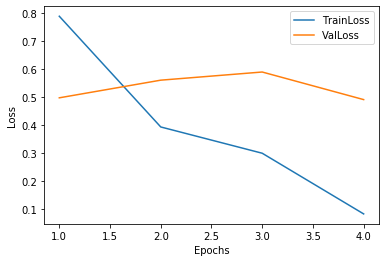

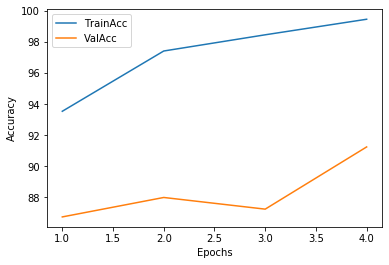

In [0]:
plot(epochs, tr_loss, val_loss, tr_acc, val_acc)

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
since = time.time()

acc = evaluate(vgg16_trained, testloader_large)

time_elapsed = time.time() - since
print('Evaluating complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

print("Accuracy on test dataset", acc, "%")


Evaluating complete in 0m 1s
Accuracy on test dataset 91.25 %


VGG(**91.25%**) performed better than Alexnet(**85.5%**) trained on same dataset with just a change of network. Because VGG is deeper than Alexnet: more features and a heavy network, in addition VGG did not use larger kernel sizes (11) in initial layers which Alexnet did so different receptive field and more robust to overfitting, which I consider one of the points where VGG got a lead.

<!--Write your report here in markdown or html-->
